In [0]:
# -*- coding: utf-8 -*- 
from __future__ import absolute_import
from __future__ import division

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame


def read_data(name, missing_flag):
    data = pd.read_excel(name).iloc[:, 2:]
    columns_name = list(data.columns)
    ##replace space  with np.nan
    data.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
    
    ##z-score
    norlizer = StandardScaler().fit(data)
    data = norlizer.transform(data)
    
    ##replace the nan with missing_flag
    data[np.isnan(data)] = missing_flag
    return data, columns_name, norlizer

def save_data(miss_data, prediction, epoch, norlizer, columns_name, missing_flag):
	###make sure the first row of you data is completed
	prediction = np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0)
	imputation = miss_data.copy()
	assert imputation.shape == prediction.shape
	imputation[miss_data == missing_flag] = prediction[miss_data == missing_flag]
	
	###reverse the data
	imputation = norlizer.inverse_transform(imputation)
	
	###save it
	new_df = DataFrame(imputation, columns=columns_name)
	new_df.to_excel('imputed_data_epoch{0}.xlsx'.format(epoch), index=None)
    

def RMSE_Metric(data, pre, missing_flag):
    data = np.array(data).copy()
    pre = np.array(pre).copy()
    assert data.shape == pre.shape
    return np.sqrt(np.mean((data[ ~(data == missing_flag)] - pre[~(data == missing_flag)])**2))
    

def ptb_iterator(raw_data, batch_size, num_steps,dim):
    row = raw_data.shape[0]
    data_num = row-num_steps+1
    if batch_size>=(data_num-1) or ((data_num-1)%batch_size!=0) :
        raise ValueError("Error, decrease batch_size or num_steps")
    data2 = np.zeros([data_num, num_steps ,dim])
    for i in range(data_num):
        data2[i] = raw_data[i:i+num_steps,:]

    batch_len=(data_num-1)//batch_size
    for i in range(batch_len):
        x = data2[i*batch_size:(i+1)*batch_size,:,:]
        y = data2[i*batch_size+1:(i+1)*batch_size+1,:,:]
        yield (x,y)

if __name__ == '__main__':
    data, columns_name, norlizer = read_data('missing_data.xlsx', missing_flag=-128.0)

In [0]:
data

array([[ 4.79689942e-02, -2.79632110e-01,  3.49560642e-01, ...,
        -3.52536027e-02,  1.71576075e+00, -7.11169764e-01],
       [ 7.24864802e-01, -3.35317585e-01,  6.82182041e-01, ...,
        -2.20292754e-01,  3.76552570e+00, -5.43369245e-01],
       [-4.03217633e-02, -8.47329466e-02,  1.58353131e-01, ...,
         9.20321716e-01,  1.58178919e+00, -1.50243697e-02],
       ...,
       [-1.28000000e+02, -3.35317585e-01, -5.31786478e-01, ...,
        -2.18253629e+00, -8.02904671e-01,  1.59578872e-01],
       [-1.28000000e+02, -1.68261159e-01, -9.47065291e-01, ...,
         4.11233902e-01, -7.76110358e-01,  3.18309093e-01],
       [-1.28000000e+02, -2.79632110e-01, -1.15420676e+00, ...,
        -2.23975125e-01, -4.81372915e-01,  3.11506369e-01]])

In [0]:
# -*- coding: utf-8 -*- 
import numpy as np
import tensorflow as tf
import reader
import os

flags = tf.flags
flags.DEFINE_integer("num_layers",1, "LSTM number of layer")
flags.DEFINE_integer("hidden_size",200, "LSTM hidden size")

flags.DEFINE_integer("embedding_size",13, "Dimension of data")
flags.DEFINE_float("missing_flag",-128.0, "missing value is marked with -128.0")

FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

variables_dict = {"W_imp": tf.Variable(tf.zeros([FLAGS.hidden_size,FLAGS.embedding_size]),
        			    name="W_imp"),
    		  "bias": tf.Variable(tf.zeros([FLAGS.embedding_size]), name="bias"),
			  #"W_r":tf.Variable(tf.zeros([FLAGS.hidden_size, FLAGS.hidden_size]), name="W_r"),
		      "W_r":tf.Variable(tf.zeros([FLAGS.hidden_size],tf.float32), name="W_r")  ### Consider diagonal W_r, reducing the number of parameters for small data set (also used in NIPS2016  
																				       ###                         "Temporal Regularized Matrix Factorization for High-dimensional Time Series Prediction")
		  }

class LIMELSTM(object):    
	def __init__(self, is_training,config,FLAGS):
		self.batch_size = batch_size = config.batch_size
		self.num_steps = num_steps = config.num_steps
		size = config.hidden_size
		embedding_size = config.embedding_size

		self.input_data = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])    # input
		self.targets = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])       # output
		lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
		cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers) 
		self.initial_state = cell.zero_state(batch_size, dtype=tf.float32)	

		state = self.initial_state 
		self.F=[]

		with tf.variable_scope("RNN"):	
			for time_step in range(num_steps):
				if time_step > 0 : tf.variable_scope(tf.get_variable_scope(), reuse=True)  	
				if time_step ==0 :
					(cell_output, state) = cell(self.input_data[:,time_step,:],state)
					self.F.append(cell_output)
				else:	
					comparison = tf.equal( self.input_data[:,time_step,:], tf.constant( FLAGS.missing_flag ) )
					temp2=tf.matmul(self.F[time_step-1], variables_dict["W_imp"]) + variables_dict["bias"]
					#change the input
					input2=tf.where(comparison, temp2, self.input_data[:,time_step,:])
					(cell_output, state) = cell(input2, state)
					#self.F.append(cell_output+tf.matmul(self.F[time_step-1],variables_dict["W_r"]))
					self.F.append(cell_output+tf.multiply(self.F[time_step-1],variables_dict["W_r"])) ### Consider diagonal W_r for small data set

        #unfolded F into the [batch, hidden_size * num_steps], and then reshape it into [batch * numsteps, hidden_size]
		F_out = tf.reshape(tf.concat(self.F, 1), [-1, size])
		self.prediction = tf.matmul(F_out, variables_dict["W_imp"]) + variables_dict["bias"]
		targets=tf.reshape(self.targets,[-1,embedding_size])

		#change the cost function
		comparison2=tf.equal(targets, tf.constant( FLAGS.missing_flag ) )
		targets=tf.where(comparison2,self.prediction,targets)

		self.cost=cost= tf.reduce_mean(tf.square(targets - self.prediction))/(batch_size)
		self.final_state = state

		if not is_training:  # if not training ,return 
			return

		self._lr = tf.Variable(0.0, trainable=False)
		self.train_op = tf.train.AdamOptimizer(self._lr).minimize(cost)
		
		self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")     
		self._lr_update = tf.assign(self._lr, self._new_lr)     
        
	def assign_lr(self, session, lr_value):
		session.run(self._lr_update, feed_dict={self._new_lr: lr_value})

class TrainConfig(object):	
	"""Train config."""
	init_scale = 0.1
	num_layers = FLAGS.num_layers		
	num_steps = 36 				
	hidden_size = FLAGS.hidden_size		
	batch_size = 6
	embedding_size=FLAGS.embedding_size


def run_epoch(session, model, data, eval_op):
	header_pre = []
	pre = []
	for step,(x,y) in enumerate(reader.ptb_iterator(data, model.batch_size,model.num_steps,FLAGS.embedding_size)):
		_, prediction= session.run([eval_op, model.prediction],
                                 {model.input_data: x,
                                  model.targets:    y})
		if step == 0:			
			header_pre.append(prediction[:model.num_steps-1,:])
		for i in range(model.batch_size):
			pre.append(prediction[(i+1)*model.num_steps - 1,:])
	
	return np.concatenate((np.array(header_pre).reshape(-1, FLAGS.embedding_size), np.array(pre)), axis=0)

def get_config(flag):
	if flag == "Train":
		return TrainConfig()
	elif flag == "Test":
		return TestConfig()
def main(_):
  config = get_config('Train')
  miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)
  
  os.environ['CUDA_VISIBLE_DEVICES']='0'
  gpu_config = tf.ConfigProto()
  gpu_config.gpu_options.allow_growth = True
  
  with tf.Session(config=gpu_config) as session:
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
    with tf.variable_scope("LIMELSTM", reuse=None, initializer=initializer):
      model = LIMELSTM(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
      
    tf.initialize_all_variables().run()
    model._lr = 0.01
    new_lr = model._lr
    for i in range(20):
      print ('Number of iterations:',i)
      prediction = run_epoch(session, model, miss_data, model.train_op)
      if i >=15:
        print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
        reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
      if i>=10 and i%10==0:
        if new_lr>0.005:new_lr=new_lr-0.003
        else:new_lr=new_lr*0.5
        model.assign_lr(session,new_lr)
    print(prediction)
if __name__ == "__main__":
	tf.app.run() 


In [0]:
import pandas as pd
x= pd.read_excel('Santa Maria WEEKLY Weather 2011-2019.xlsx')

In [0]:
x.columns

Index(['Unnamed: 0', 'Date', 'ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)',
       'Avg Vap Pres (mBars)', 'Max Air Temp (F)', 'Min Air Temp (F)',
       'Avg Air Temp (F)', 'Max Rel Hum (%)', 'Min Rel Hum (%)',
       'Avg Rel Hum (%)', 'Dew Point (F)', 'Avg Wind Speed (mph)',
       'Avg Soil Temp (F)'],
      dtype='object')

In [0]:
x=x.drop(columns=['Unnamed: 0', 'Date'])

In [0]:
y = pd.read_excel('imputed_data_epoch19.xlsx')

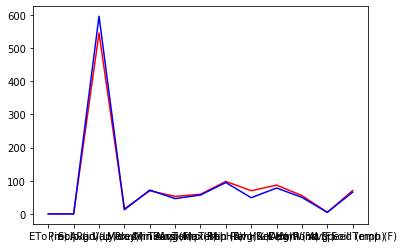

In [0]:
import matplotlib.pyplot as plt

plt.plot(x.iloc[15],color='r')
plt.plot(y.iloc[15],color='b')
plt.show()

MAIN thing

In [0]:
import random
def misser (df,missing_percent = 0.5):
  for i in df.columns:
    for j, row_value in df[i].iteritems():
        if random.random() <= missing_percent:
            df[i][j] = np.nan
  return df


In [0]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict

In [0]:
df= pd.read_excel('Santa Daily Interpolated copy.xlsx')

In [0]:
df.isnull().sum()

ETo (in)                0
Precip (in)             0
Sol Rad (Ly/day)        0
Avg Vap Pres (mBars)    0
Max Air Temp (F)        0
Min Air Temp (F)        0
Avg Air Temp (F)        0
Max Rel Hum (%)         0
Min Rel Hum (%)         0
Avg Rel Hum (%)         0
Dew Point (F)           0
Avg Wind Speed (mph)    0
Avg Soil Temp (F)       0
dtype: int64

In [0]:
miss_df = misser(df,0.5)

In [0]:
miss_df.isnull().sum()

ETo (in)                1550
Precip (in)             1606
Sol Rad (Ly/day)        1548
Avg Vap Pres (mBars)    1592
Max Air Temp (F)        1561
Min Air Temp (F)        1582
Avg Air Temp (F)        1640
Max Rel Hum (%)         1568
Min Rel Hum (%)         1592
Avg Rel Hum (%)         1591
Dew Point (F)           1652
Avg Wind Speed (mph)    1559
Avg Soil Temp (F)       1588
dtype: int64

In [0]:
for i,j in zip(miss_df.columns,range(0,len(miss_df.columns))):
  miss_df_j=miss_df[i]


In [0]:
miss_np = miss_df.to_numpy()

In [0]:
miss_np.shape
print(len(miss_np))

3156


In [0]:
headers = miss_df.columns

In [0]:
var1=pd.DataFrame()

In [0]:
var1=miss_df['ETo (in)']

In [0]:
var1

0        NaN
1        NaN
2       0.11
3       0.16
4       0.15
        ... 
3151    0.14
3152     NaN
3153    0.14
3154     NaN
3155    0.14
Name: ETo (in), Length: 3156, dtype: float64

In [0]:
import csv
import pandas as pd

# csv_reader = csv.reader('USDAProj_Corn_2007to2008.csv', delimiter=',')

df= pd.read_csv('USDAProj_Corn_2007to2008.csv')

In [0]:
print(df.columns)

Index(['Date', 'Area Planted', 'Area Harvested', 'Yield', 'Beginning Stocks',
       'Production', 'Imports', 'Total Supply', 'Feed and Residual', 'FSI',
       ...
       'Southeast Asia DomesticTotal', 'Southeast Asia Exports',
       'Southeast Asia EndingStocks', 'European Union BeginningStocks',
       'European Union Production', 'European Union Imports',
       'European Union DomesticFeed', 'European Union DomesticTotal',
       'European Union Exports', 'European Union EndingStocks'],
      dtype='object', length=113)


In [0]:
df1 = df[[ 'Area Planted']]

In [0]:
df1.columns

Index(['Area Planted'], dtype='object')

In [0]:
df1.head()

,Area Planted
0,90.5
1,90.5
2,92.9
3,92.9
4,92.9


In [0]:
df1.isnull().sum()

Area Planted    0
dtype: int64

In [0]:
miss_df = misser(df1,0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
miss_df.isnull().sum()

Area Planted    8
dtype: int64

In [0]:
miss_df['Index']=np.arange(len(miss_df))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
miss_df.head()

,Area Planted,Index
0,90.5,0
1,90.5,1
2,92.9,2
3,92.9,3
4,92.9,4


In [0]:
df_train_x = miss_df.copy(deep=True)

In [0]:
df_train_wna=df_train_x.dropna()

In [0]:
df_pred_na = df_train_x[df_train_x['Area Planted'].isnull()]

In [0]:
df_pred_na.head(8)

,Area Planted,Index
5,NaN,5
6,NaN,6
10,NaN,10
12,NaN,12
14,NaN,14
15,NaN,15
21,NaN,21
22,NaN,22


In [0]:
output = df[['Yield']]

In [0]:
output['Index1']=np.arange(len(output))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
output.head()

,Yield,Index1
0,150.3,0
1,150.3,1
2,150.3,2
3,152.8,3
4,155.8,4


In [0]:
df = df[df.index.isin(df1.index)]

In [0]:
output_train=output[output.index.isin(df_train_wna['Index'])]

In [0]:
output_train

In [0]:
output_pred = output[output.index.isin(df_pred_na['Index'])]

In [0]:
output_pred

,Yield,Index1
5,154.7,5
6,153.0,6
10,151.1,10
12,151.1,12
14,151.1,14
15,151.1,15
21,150.7,21
22,150.7,22


In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
reg = LinearRegression().fit(np_x,df_train_wna['Area Planted'])
reg.score(np_x,df_train_wna['Area Planted'])

# reg.coef_

# reg.intercept_

# reg.predict(np.array([[3, 5]]))

0.03100585325808769

In [0]:
from scipy.stats.stats import pearsonr
docs_col = output_train.values
energy_col = df_train_wna.values
corr , _ = pearsonr(docs_col, energy_col)

TypeError: ignored

In [0]:
np_x=np_x.reshape(-1,1)

In [0]:
np_x.reshape([16,1])

array([[150.3],
       [150.3],
       [150.3],
       [152.8],
       [155.8],
       [153. ],
       [151.1],
       [151.1],
       [151.1],
       [151.1],
       [151.1],
       [151.1],
       [151.1],
       [151.1],
       [150.7],
       [150.7]])

In [0]:
np_x.shape

(16, 1)

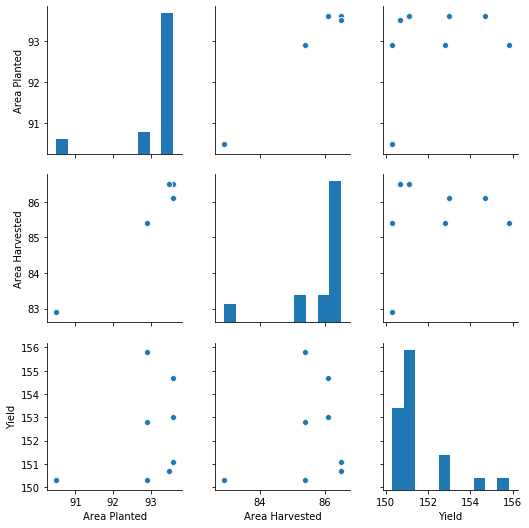

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure
sns.pairplot(data=df[['Date', 'Area Planted', 'Area Harvested', 'Yield']],dropna=True)

In [0]:
from scipy.stats import pearsonr

for i in df.columns:
  corr, p_value = pearsonr(df["Area Planted"], df[i])
  print("The correlation between Area Planted and",i,"is:",corr)
  

In [0]:
corr, p_value = pearsonr(df["Area Planted"], df["Yield"])

In [0]:
corr

0.17144594446518047

In [0]:
df["Area Planted"].shape

(24,)

In [0]:
df['Yield'].shape

(24,)

In [0]:
df['Yield'].head(26)

0                                                     150.3
1                                                     150.3
2                                                     150.3
3                                                     152.8
4                                                     155.8
5                                                     154.7
6                                                       153
7                                                       153
8                                                     151.1
9                                                     151.1
10                                                    151.1
11                                                    151.1
12                                                    151.1
13                                                    151.1
14                                                    151.1
15                                                    151.1
16                                      

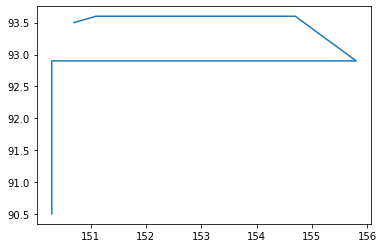

In [0]:
plt.plot(df['Yield'],df['Area Planted'])

# Actual Code

Importing Libraries 

In [0]:
import pandas as pd
import numpy as np 
import random
import csv
import matplotlib.pyplot as plt
import xlwt 
import keras
import os
import tensorflow as tf
import reader
from keras import backend as K
from xlwt import Workbook
from keras import optimizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Bidirectional,Activation
from sklearn.svm import SVR
from sklearn import ensemble

Using TensorFlow backend.


Defining Functions

In [0]:
EPSILON = 1

def data(dataframe,input_var,output_var):
  temp_input = dataframe[[input_var]]
  temp_output = dataframe[[output_var]]

  # temp_in_miss = misser(temp_input,percent)

  temp_in_miss = temp_input.copy(deep=True)

  temp_in_miss['Index_input']=np.arange(len(temp_in_miss))
  temp_output['Index_output']=np.arange(len(temp_output))

  temp_in_wna = temp_in_miss.dropna()
  temp_in_na = temp_in_miss[temp_in_miss[input_var].isnull()]

  output_train=temp_output[temp_output.index.isin(temp_in_wna['Index_input'])]
  output_pred= temp_output[temp_output.index.isin(temp_in_na['Index_input'])]

  return temp_in_wna,temp_in_na,output_train,output_pred


def misser (df,missing_percent = 0.5):
  for i in df.columns:
    for j, row_value in df[i].iteritems():
      if j==0:
        continue
      else:
        if random.random() <= missing_percent:
            df[i][j] = np.nan
  return df

def LR (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = LinearRegression()
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na

def SR (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = SVR()
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na

def XGB (input_wna,output_wna,input_na,output_na,input_var,output_var):
  reg = ensemble.GradientBoostingRegressor()
  reg.fit(
      (input_wna[input_var].to_numpy()).reshape(-1,1),
      output_wna[output_var].to_numpy()
      )
  ans=reg.predict(
      (input_na[input_var].to_numpy()).reshape(-1,1)
      )
  output_na[output_var]=ans.reshape(-1,1)

  return output_na


def merger(input_wna,input_na):
  return (input_wna.append(input_na)).sort_values(by='Index_input')

def data_split(dataframe,percentage):
  training = dataframe[(dataframe.index>=np.percentile(dataframe.index, 0)) & (dataframe.index<=np.percentile(dataframe.index, percentage))]
  testing = dataframe[(dataframe.index>=np.percentile(dataframe.index, percentage)) & (dataframe.index<=np.percentile(dataframe.index, 100))]

  return training, testing

def create_dataset(df,lookback=5,lookahead=0,jumps=6):

  x = []
  y = []
  for i in range(lookback, df.shape[0]-lookahead,jumps):
      x.append(df[i-lookback:i, 0])
      y.append(df[i+lookahead, 0])
  x = np.array(x)
  y = np.array(y)
  return x,y


def _percentage_error(actual, predicted):
  """
  Percentage error
  Note: result is NOT multiplied by 100
  """
  return _error(actual, predicted) / (actual+EPSILON )
  
def _error(actual, predicted):
  """ Simple error """
  return actual - predicted
  
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def smape(actual, predicted):
  """
  Symmetric Mean Absolute Percentage Error
  Note: result is NOT multiplied by 100
  """
  return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))
  
def rmspe(actual, predicted):
  """
  Root Mean Squared Percentage Error
  Note: result is NOT multiplied by 100
  """
  return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))
  
def mdape(actual, predicted):
  """
  Median Absolute Percentage Error
  Note: result is NOT multiplied by 100
  """
  return np.median(np.abs(_percentage_error(actual, predicted)))

def mape(actual, predicted):
    
  return np.mean(np.abs(_percentage_error(actual, predicted)))

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

def RNN_run(train_data,test_data,epochs,title,lb=5,la=0,j=6):

  ## training data preparation
  temp_train_single_col = pd.DataFrame({'Header':train_data.values.ravel()})
  temp_train = temp_train_single_col['Header'].values.reshape(-1,1)

  x_train,y_train = create_dataset(temp_train,lb,la,j)

  ##testing data preparation
  temp_test_single_col = pd.DataFrame({'Header1':test_data.values.ravel()})
  temp_test = temp_test_single_col['Header1'].values.reshape(-1,1)

  x_test,y_test = create_dataset(temp_test,lb,la,j)

  sgd = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
  keras.backend.set_epsilon(1)
  wb=Workbook()
  sheet1 = wb.add_sheet('Sheet 1')

  # keras.backend.clear_session()
  os.environ['PYTHONHASHSEED']='42'
  np.random.seed(42)
  tf.random.set_random_seed(seed=42)
  np.random.RandomState(42)
  random.seed(42)

  filepath_lstm = "best_weights_{}.hdf5".format(title)
  checkpoint = keras.callbacks.ModelCheckpoint(filepath_lstm,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True,
                             mode = 'min')

  print("Prediction started")
  # x_train, y_train = create_dataset(dataset_train,21,0)
  # x_test, y_test = create_dataset(dataset_test,21,0)
  x_train1 = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  x_test1 = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  print(x_train1.shape)
  print(x_test1.shape)

  main_model= Sequential()
  main_model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train1.shape[1], 1)))
  main_model.add(Dropout(0.2))
  main_model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train1.shape[1], 1)))
  main_model.add(keras.layers.Flatten())
  main_model.add(Dropout(0.2))
  main_model.add(Dense(units=30))
  main_model.add(Activation("relu"))
  main_model.add(Dense(units=1))

  main_model.compile(loss='mse', optimizer=sgd ,metrics=['mae','mse', 'mape',coeff_determination])

  if(not os.path.exists('stock_prediction.h5')):
    history=main_model.fit(x_train1, y_train, epochs=epochs,batch_size=100,validation_data=(x_test1,y_test),callbacks=[checkpoint])
    plt.plot(history.history['mean_squared_error'],color="red")
    plt.plot(history.history['val_mean_squared_error'],color='blue')
    #plt.plot(history.history['mean_absolute_error'])
    #plt.plot(history.history['mean_absolute_percentage_error'])
    #plt.plot(history.history['cosine_proximity'])
    plt.show()
    y_pred = main_model.predict((x_test1))
    plt.plot(np.arange(len(y_test)), y_test, color='r', label='actual')
    plt.plot(np.arange(len(y_test)), y_pred, color='b', label='predicted')
    plt.title("RNN Results")
    plt.legend()
    plt.show()
    # plt.savefig('Weather to price 2 Week.png')
    print("----------------------------------------------------------------")
    plt.plot(np.arange(len(y_test))[:50], y_test[:50], color='r', label='actual')
    plt.plot(np.arange(len(y_test))[:50], y_pred[:50], color='b', label='predicted')
    plt.show()
    print('-----------------------------------------------------------------')
  print("====================================================================================================================")

  i=0
  sheet1.write(i+1,0,history.history['val_mean_absolute_percentage_error'][-1])
  sheet1.write(i+1,1,history.history['val_mean_absolute_error'][-1])
  sheet1.write(i+1,2,history.history['val_coeff_determination'][-1])
  sheet1.write(i+1,3,smape(y_test,main_model.predict(x_test1)))
  sheet1.write(i+1,4,rmspe(y_test,main_model.predict(x_test1)))
  sheet1.write(i+1,5,mdape(y_test,main_model.predict(x_test1)))
  sheet1.write(i+1,6,history.history['val_mean_squared_error'][-1])
    

  wb.save('RNN Results for {}.xls'.format(title)) 

Defining LIME

In [0]:
# flags = tf.flags
# flags.DEFINE_integer("num_layers",1, "LSTM number of layer")
# flags.DEFINE_integer("hidden_size",200, "LSTM hidden size")

# flags.DEFINE_integer("embedding_size",5, "Dimension of data")
# flags.DEFINE_float("missing_flag",-128.0, "missing value is marked with -128.0")

# FLAGS = flags.FLAGS
# tf.app.flags.DEFINE_string('f', '', 'kernel')

variables_dict = {"W_imp": tf.Variable(tf.zeros([FLAGS.hidden_size,FLAGS.embedding_size]),
        			    name="W_imp"),
    		  "bias": tf.Variable(tf.zeros([FLAGS.embedding_size]), name="bias"),
			  #"W_r":tf.Variable(tf.zeros([FLAGS.hidden_size, FLAGS.hidden_size]), name="W_r"),
		      "W_r":tf.Variable(tf.zeros([FLAGS.hidden_size],tf.float32), name="W_r")  ### Consider diagonal W_r, reducing the number of parameters for small data set (also used in NIPS2016  
																				       ###                         "Temporal Regularized Matrix Factorization for High-dimensional Time Series Prediction")
		  }

class LIMELSTM(object):    
	def __init__(self, is_training,config,FLAGS):
		self.batch_size = batch_size = config.batch_size
		self.num_steps = num_steps = config.num_steps
		size = config.hidden_size
		embedding_size = config.embedding_size

		self.input_data = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])    # input
		self.targets = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])       # output
		lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
		cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers) 
		self.initial_state = cell.zero_state(batch_size, dtype=tf.float32)	

		state = self.initial_state 
		self.F=[]

		with tf.variable_scope("RNN"):	
			for time_step in range(num_steps):
				if time_step > 0 : tf.variable_scope(tf.get_variable_scope(), reuse=True)  	
				if time_step ==0 :
					(cell_output, state) = cell(self.input_data[:,time_step,:],state)
					self.F.append(cell_output)
				else:	
					comparison = tf.equal( self.input_data[:,time_step,:], tf.constant( FLAGS.missing_flag ) )
					temp2=tf.matmul(self.F[time_step-1], variables_dict["W_imp"]) + variables_dict["bias"]
					#change the input
					input2=tf.where(comparison, temp2, self.input_data[:,time_step,:])
					(cell_output, state) = cell(input2, state)
					#self.F.append(cell_output+tf.matmul(self.F[time_step-1],variables_dict["W_r"]))
					self.F.append(cell_output+tf.multiply(self.F[time_step-1],variables_dict["W_r"])) ### Consider diagonal W_r for small data set

        #unfolded F into the [batch, hidden_size * num_steps], and then reshape it into [batch * numsteps, hidden_size]
		F_out = tf.reshape(tf.concat(self.F, 1), [-1, size])
		self.prediction = tf.matmul(F_out, variables_dict["W_imp"]) + variables_dict["bias"]
		targets=tf.reshape(self.targets,[-1,embedding_size])

		#change the cost function
		comparison2=tf.equal(targets, tf.constant( FLAGS.missing_flag ) )
		targets=tf.where(comparison2,self.prediction,targets)

		self.cost=cost= tf.reduce_mean(tf.square(targets - self.prediction))/(batch_size)
		self.final_state = state

		if not is_training:  # if not training ,return 
			return

		self._lr = tf.Variable(0.0, trainable=False)
		self.train_op = tf.train.AdamOptimizer(self._lr).minimize(cost)
		
		self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")     
		self._lr_update = tf.assign(self._lr, self._new_lr)     
        
	def assign_lr(self, session, lr_value):
		session.run(self._lr_update, feed_dict={self._new_lr: lr_value})

class LIMEGRU(object):    
	def __init__(self, is_training,config,FLAGS):
		self.batch_size = batch_size = config.batch_size
		self.num_steps = num_steps = config.num_steps
		size = config.hidden_size
		embedding_size = config.embedding_size

		self.input_data = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])    # input
		self.targets = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])       # output
		GRU_cell = tf.nn.rnn_cell.GRUCell(size)
		cell = tf.nn.rnn_cell.MultiRNNCell([GRU_cell] * config.num_layers) 
		self.initial_state = cell.zero_state(batch_size, dtype=tf.float32)	

		state = self.initial_state 
		self.F=[]

		with tf.variable_scope("RNN"):	
			for time_step in range(num_steps):
				if time_step > 0 : tf.variable_scope(tf.get_variable_scope(), reuse=True)  	
				if time_step ==0 :
					(cell_output, state) = cell(self.input_data[:,time_step,:],state)
					self.F.append(cell_output)
				else:	
					comparison = tf.equal( self.input_data[:,time_step,:], tf.constant( FLAGS.missing_flag ) )
					temp2=tf.matmul(self.F[time_step-1], variables_dict["W_imp"]) + variables_dict["bias"]
					#change the input
					input2=tf.where(comparison, temp2, self.input_data[:,time_step,:])
					(cell_output, state) = cell(input2, state)
					#self.F.append(cell_output+tf.matmul(self.F[time_step-1],variables_dict["W_r"]))
					self.F.append(cell_output+tf.multiply(self.F[time_step-1],variables_dict["W_r"])) ### Consider diagonal W_r for small data set

        #unfolded F into the [batch, hidden_size * num_steps], and then reshape it into [batch * numsteps, hidden_size]
		F_out = tf.reshape(tf.concat(self.F, 1), [-1, size])
		self.prediction = tf.matmul(F_out, variables_dict["W_imp"]) + variables_dict["bias"]
		targets=tf.reshape(self.targets,[-1,embedding_size])

		#change the cost function
		comparison2=tf.equal(targets, tf.constant( FLAGS.missing_flag ) )
		targets=tf.where(comparison2,self.prediction,targets)

		self.cost=cost= tf.reduce_mean(tf.square(targets - self.prediction))/(batch_size)
		self.final_state = state

		if not is_training:  # if not training ,return 
			return

		self._lr = tf.Variable(0.0, trainable=False)
		self.train_op = tf.train.AdamOptimizer(self._lr).minimize(cost)
		
		self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")     
		self._lr_update = tf.assign(self._lr, self._new_lr)  

class TrainConfig(object):	
	"""Train config."""
	init_scale = 0.1
	num_layers = FLAGS.num_layers		
	num_steps = 1 				
	hidden_size = FLAGS.hidden_size		
	batch_size = 1
	embedding_size=FLAGS.embedding_size


def run_epoch(session, model, data, eval_op):
	header_pre = []
	pre = []
	for step,(x,y) in enumerate(reader.ptb_iterator(data, model.batch_size,model.num_steps,FLAGS.embedding_size)):
		_, prediction= session.run([eval_op, model.prediction],
                                 {model.input_data: x,
                                  model.targets:    y})
		if step == 0:			
			header_pre.append(prediction[:model.num_steps-1,:])
		for i in range(model.batch_size):
			pre.append(prediction[(i+1)*model.num_steps - 1,:])
	
	return np.concatenate((np.array(header_pre).reshape(-1, FLAGS.embedding_size), np.array(pre)), axis=0)

def get_config(flag):
	if flag == "Train":
		return TrainConfig()
	elif flag == "Test":
		return TestConfig()
	

def LIME_LSTM_Run(epochs):
  config = get_config('Train')
  miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)
  
  os.environ['CUDA_VISIBLE_DEVICES']='0'
  gpu_config = tf.ConfigProto()
  gpu_config.gpu_options.allow_growth = True
  
  with tf.Session(config=gpu_config) as session:
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
    with tf.variable_scope("LIMELSTM", reuse=None, initializer=initializer):
      model = LIMELSTM(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
      
    tf.initialize_all_variables().run()
    model._lr = 0.01
    new_lr = model._lr
    for i in range(epochs):
      print ('Number of iterations:',i)
      prediction = run_epoch(session, model, miss_data, model.train_op)
      if i >=(epochs//2):
        print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
      if i == (epochs-1):
        reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
      if i>=10 and i%10==0:
        if new_lr>0.005:new_lr=new_lr-0.003
        else:new_lr=new_lr*0.5
        model.assign_lr(session,new_lr)
  print(prediction)

def LIME_GRU_Run(epochs):
  config = get_config('Train')
  miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)
  
  os.environ['CUDA_VISIBLE_DEVICES']='0'
  gpu_config = tf.ConfigProto()
  gpu_config.gpu_options.allow_growth = True
  
  with tf.Session(config=gpu_config) as session:
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
    with tf.variable_scope("LIMELSTM", reuse=None, initializer=initializer):
      model = LIMELSTM(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
      
    tf.initialize_all_variables().run()
    model._lr = 0.01
    new_lr = model._lr
    for i in range(epochs):
      print ('Number of iterations:',i)
      prediction = run_epoch(session, model, miss_data, model.train_op)
      if i >=(epochs//2):
        print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
      if i == (epochs-1):
        reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
      if i>=10 and i%10==0:
        if new_lr>0.005:new_lr=new_lr-0.003
        else:new_lr=new_lr*0.5
        model.assign_lr(session,new_lr)
  print(prediction)

def LIME_RNN_Run(epochs):
  config = get_config('Train')
  miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)
  
  os.environ['CUDA_VISIBLE_DEVICES']='0'
  gpu_config = tf.ConfigProto()
  gpu_config.gpu_options.allow_growth = True
  
  with tf.Session(config=gpu_config) as session:
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
    with tf.variable_scope("LIMERNN", reuse=None, initializer=initializer):
      model = LIMERNN(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
      
    tf.initialize_all_variables().run()
    model._lr = 0.01
    new_lr = model._lr
    for i in range(epochs):
      print ('Number of iterations:',i)
      prediction = run_epoch(session, model, miss_data, model.train_op)
      if i >=(epochs//2):
        print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
      if i == (epochs-1):
        reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
      if i>=10 and i%10==0:
        if new_lr>0.005:new_lr=new_lr-0.003
        else:new_lr=new_lr*0.5
        model.assign_lr(session,new_lr)
  print(prediction)


Main Section

*Machine Learning Bucket*

In [0]:
df=pd.read_excel('Combined file_corn.xls')
df=df[['Area Planted', 'Area Harvested', 'Beginning Stocks','Production', 'Imports', 'Yield']]

df_missing = df[['Area Planted', 'Area Harvested', 'Beginning Stocks','Production', 'Imports']]

df_missing_file = misser(df_missing,0.75)

df_missing_file =pd.concat([df_missing_file,df["Yield"]],axis=1)

# df_interpolated_LR,df_interpolated_SR,df_interpolated_XGB=df.copy(deep=True),df.copy(deep=True),df.copy(deep=True)

# for i in df.columns:
#   if i == "Yield":
#     break
#   else:
#     in_wna,in_na,out_wna,out_na= data(df_missing_file,i,'Yield')
    
#     pred_output_LR = LR(out_wna,in_wna,out_na,in_na,'Yield',i)
#     pred_output_SR = SR(out_wna,in_wna,out_na,in_na,'Yield',i)
#     pred_output_XGB = XGB(out_wna,in_wna,out_na,in_na,'Yield',i)

#     comp_input_LR=merger(pred_output_LR,in_wna)
#     comp_input_SR=merger(pred_output_SR,in_wna)
#     comp_input_XGB=merger(pred_output_XGB,in_wna)
    
#     df_interpolated_LR[i]=comp_input_LR
#     df_interpolated_SR[i]=comp_input_SR
#     df_interpolated_XGB[i]=comp_input_XGB

# train_LR,test_LR = data_split(df_interpolated_LR,80)
# train_SR,test_SR = data_split(df_interpolated_SR,80)
# train_XGB,test_XGB = data_split(df_interpolated_XGB,80)

# RNN_run(train_LR,test_LR,500,"Linear Regression",lb=5,la=0,j=6)
# RNN_run(train_SR,test_SR,500,"SV Regression",lb=5,la=0,j=6)
# RNN_run(train_XGB,test_XGB,500,"XGBoost",lb=5,la=0,j=6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1221

Graphs

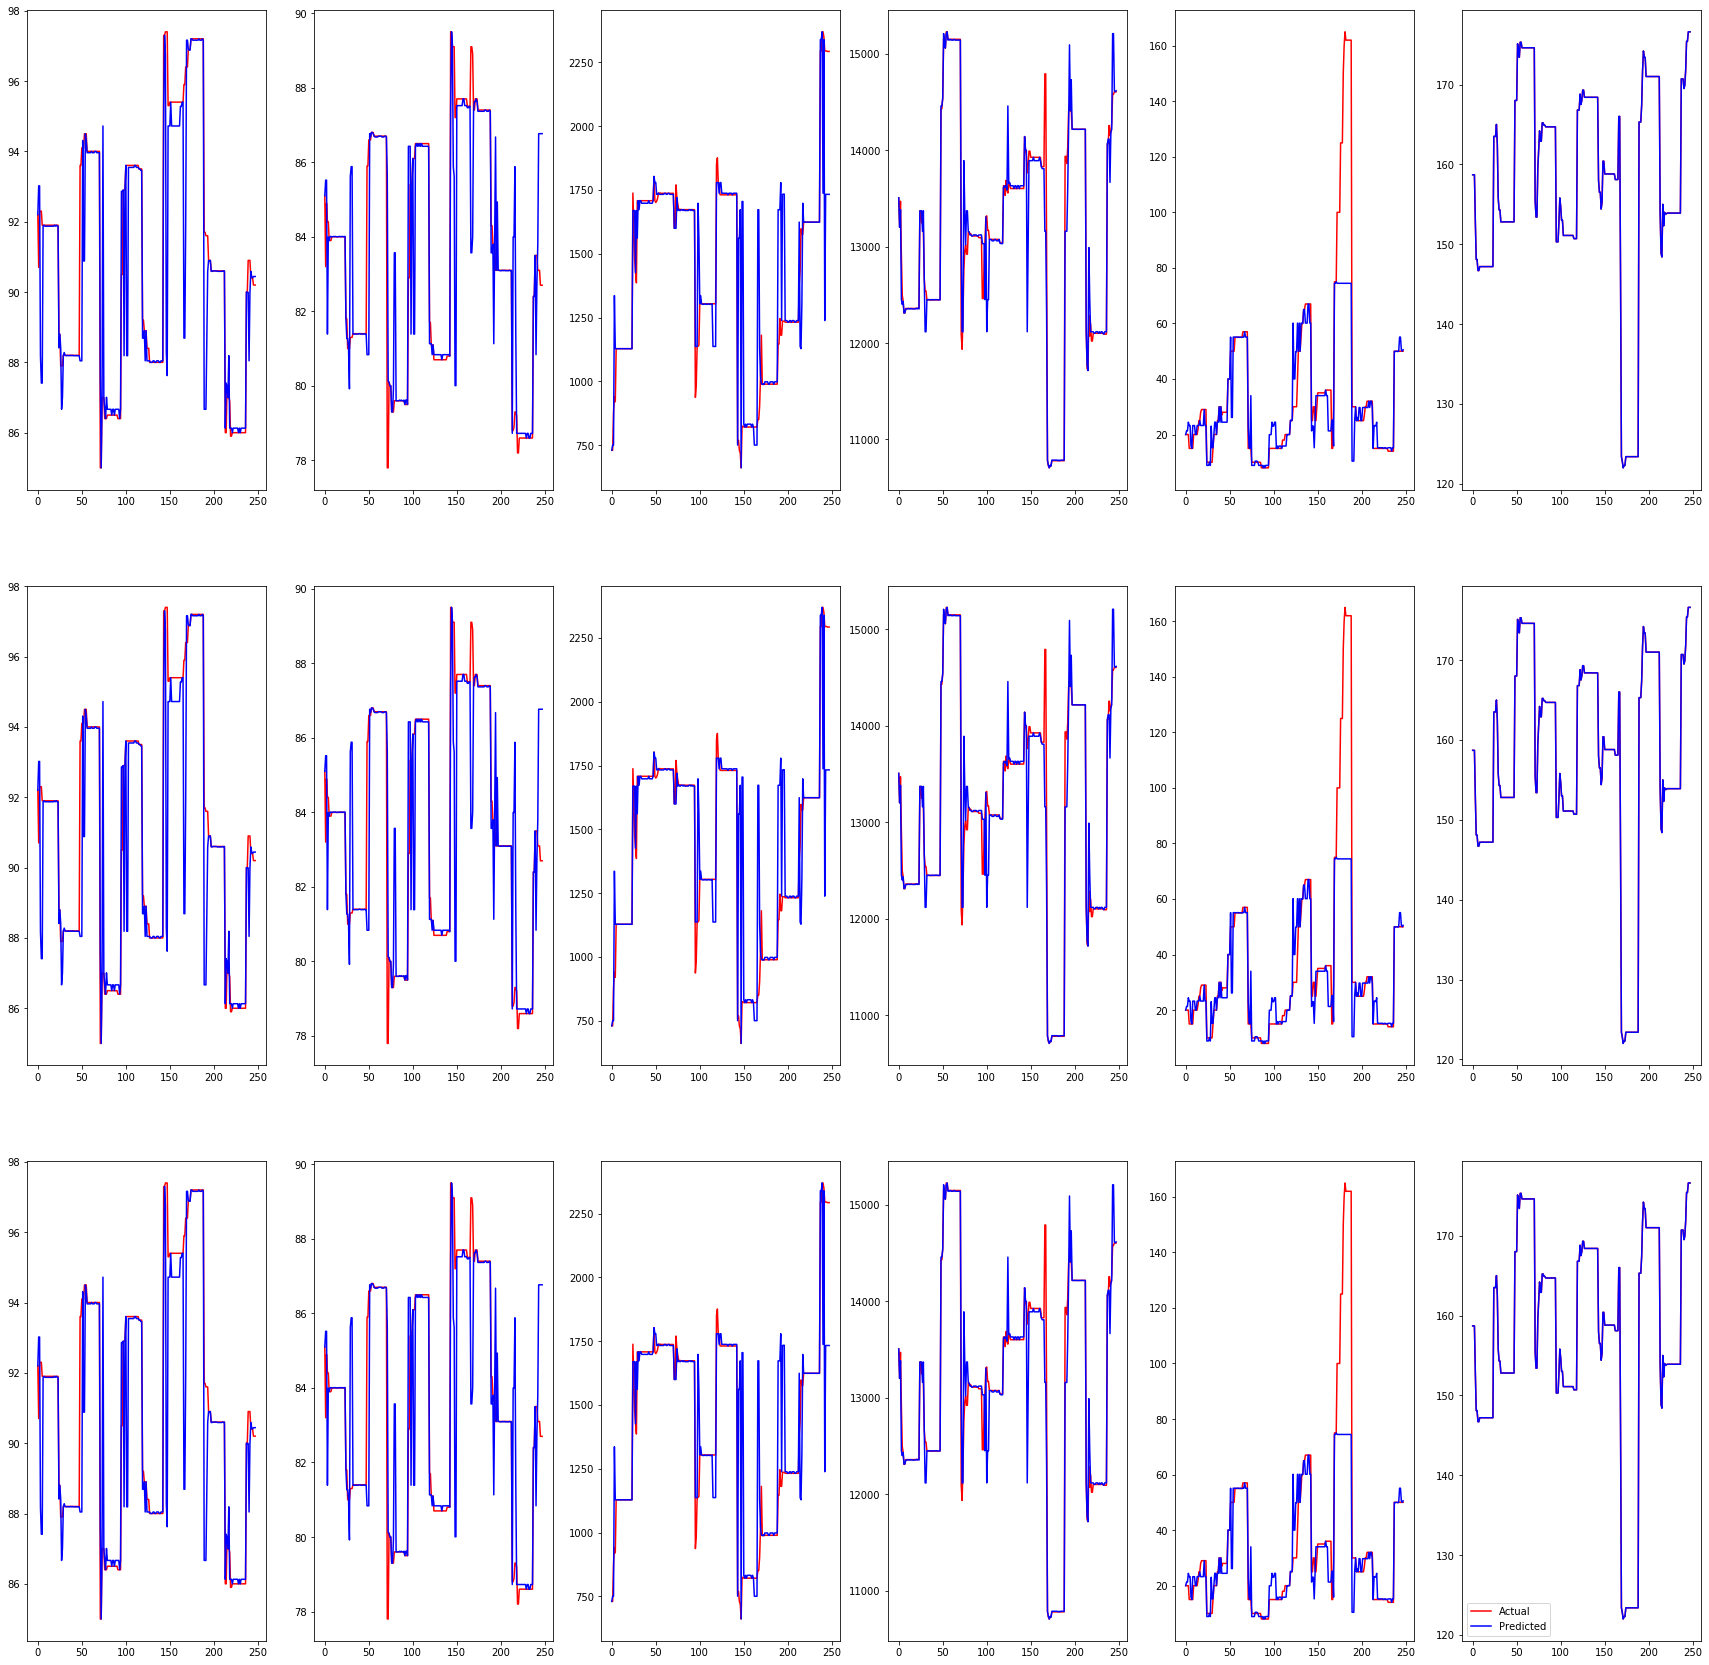

In [0]:
fig,axs = plt.subplots(3,6,figsize=(30,30))

for i,j in zip(df.columns,range(0,len(df.columns))):

  axs[0,j].plot(df[i],color='r',label="Actual")
  axs[0,j].plot(df_interpolated_LR[i],color='b',label='Predicted')

for k,l in zip(df.columns,range(0,len(df.columns))):
  axs[1,l].plot(df[k],color='r',label="Actual")
  axs[1,l].plot(df_interpolated_SR[k],color='b',label='Predicted')

for p,q in zip(df.columns,range(0,len(df.columns))):
  axs[2,q].plot(df[p],color='r',label="Actual")
  axs[2,q].plot(df_interpolated_XGB[p],color='b',label='Predicted')

plt.legend()




Baseline 

Prediction started
(198, 5, 1)
(50, 5, 1)
Train on 198 samples, validate on 50 samples
Epoch 1/500
198/198 [==============================] - 3s 13ms/step - loss: 24698.4851 - mean_absolute_error: 156.5323 - mean_squared_error: 24698.4851 - mean_absolute_percentage_error: 100.0099 - coeff_determination: -129.0329 - val_loss: 26524.1699 - val_mean_absolute_error: 162.5906 - val_mean_squared_error: 26524.1699 - val_mean_absolute_percentage_error: 99.7305 - val_coeff_determination: -299.2480
Epoch 2/500
198/198 [==============================] - 0s 287us/step - loss: 24517.8823 - mean_absolute_error: 155.9572 - mean_squared_error: 24517.8823 - mean_absolute_percentage_error: 99.6413 - coeff_determination: -125.0360 - val_loss: 26336.5801 - val_mean_absolute_error: 162.0126 - val_mean_squared_error: 26336.5801 - val_mean_absolute_percentage_error: 99.3748 - val_coeff_determination: -297.1246
Epoch 3/500
198/198 [==============================] - 0s 243us/step - loss: 24331.3992 - mean_abso

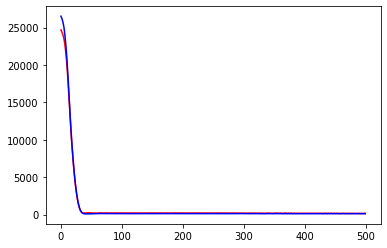

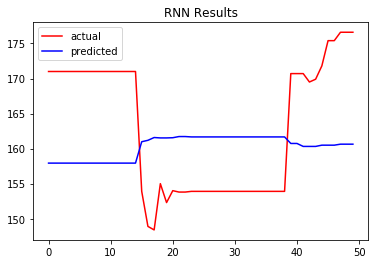

----------------------------------------------------------------


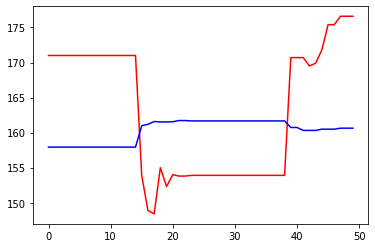

-----------------------------------------------------------------


In [0]:
train_BL,test_BL = data_split(df,80)
RNN_run(train_BL,test_BL,500,"Baseline",lb=5,la=0,j=6)

LIME Run

In [0]:
# df_missing_file.to_excel('missing_data.xlsx')
iteration=500

del_all_flags(tf.flags.FLAGS)
keras.backend.clear_session()

LIME_Run(epochs=iteration)

df_lime = pd.read_excel('imputed_data_epoch{}.xlsx'.format(iteration-1))
# df_lime=pd.concat([df_lime,df['Yield']],axis=1)

# df_lime_train,df_lime_test=data_split(df_lime,80)

# RNN_run(df_lime_train,df_lime_test,500,"LIME RNN",lb=5,la=0,j=6)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Number of iterations: 0
Number of iterations: 1
Number of iterations: 2
Number of iterations: 3
Number of iterations: 4
Number of iterations: 5
Number of iterations: 6
Number of iterations: 7
Number of iterations: 8
Number of iterations: 9
Number of iterations: 10
Number of iterations: 11
Number of iterations: 12
Number of iterations: 13
Number of iterations: 14
Number of iterations: 15
Number of iterations: 16
Number of iterations: 17
Number of iterations: 18
Number of iterations: 19
Number of iterations: 20
Number of iterations: 21
Number of iterations: 22
Number of iterations: 23
Number of iterations: 24
Number of iterations: 25
Number of iterations: 26
Number of iterations: 27
Number of iterations: 28
Number of iterations: 29
Number of iterations: 30
Number of iterations: 31
Number of iterations: 32
Number of iterations: 33
Number of iterations: 34
Number

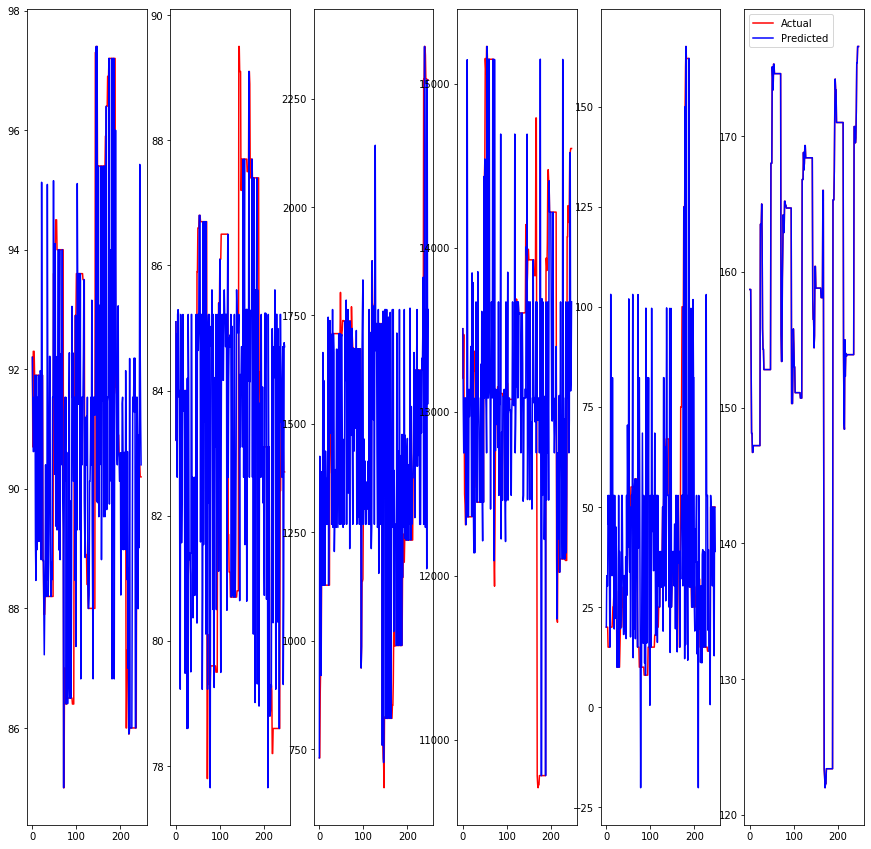

In [0]:
fig,axs = plt.subplots(1,6,figsize=(15,15))

for i,j in zip(df.columns,range(0,len(df.columns))):

  axs[j].plot(df[i],color='r',label="Actual")
  axs[j].plot(df_lime[i],color='b',label='Predicted')

plt.legend()




Statistical Methods

In [0]:
# Plugging in the average
df_avg = df_missing_file.copy(deep=True)
df_avg=df_avg.fillna(df_avg.mean())

# df_avg_train,df_avg_test = data_split(df_avg,80)

# RNN_run(df_avg_train,df_avg_test,500,"Simple Average",lb=5,la=0,j=6)

# previous and next month means

df_inter = df_missing_file.copy(deep=True)

for i in df_inter.columns:
  df_inter[i]=df_inter[i].interpolate(limit_direction='both')

# df_inter_train,df_inter_test = data_split(df_inter,80)

# RNN_run(df_inter_train,df_inter_test,500,"Previous & Next Months Mean",lb=5,la=0,j=6)

#Spline interpolation

df_spline = df_missing_file.copy(deep=True)

for j in df_spline.columns:
  df_spline[i]=df_spline[i].interpolate(method='spline',order=4)

# df_spline_train,df_spline_test =data_split(df_spline,80)

# RNN_run(df_spline_train,df_spline_test,500,"Spline Interpolation",lb=5,la=0,j=6)


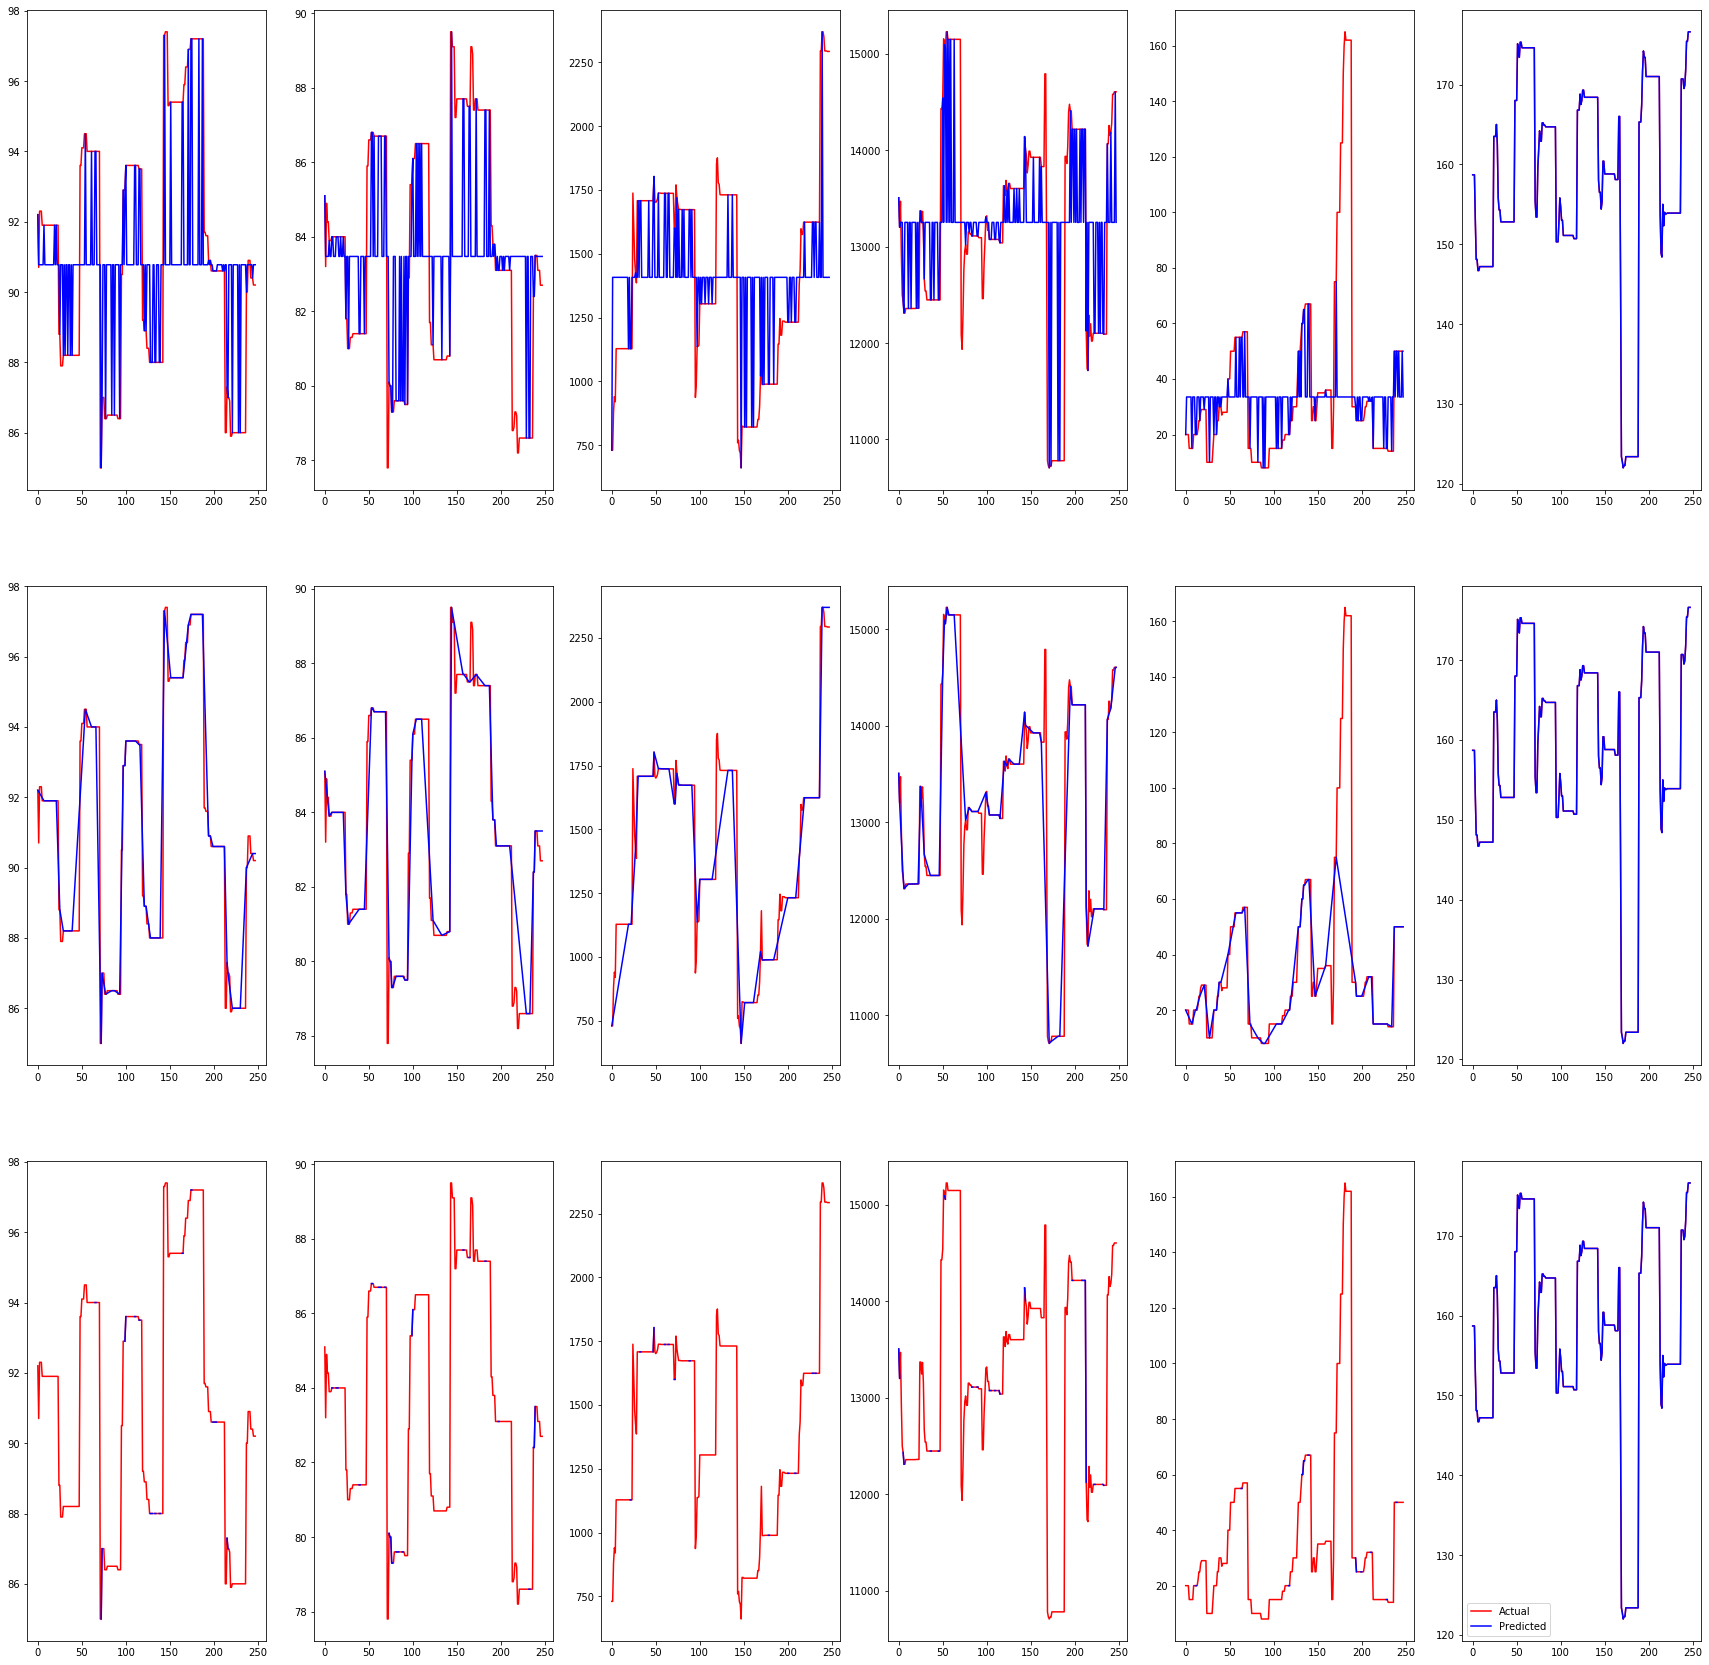

In [0]:
fig,axs = plt.subplots(3,6,figsize=(30,30))

for i,j in zip(df.columns,range(0,len(df.columns))):

  axs[0,j].plot(df[i],color='r',label="Actual")
  axs[0,j].plot(df_avg[i],color='b',label='Predicted')

for k,l in zip(df.columns,range(0,len(df.columns))):
  axs[1,l].plot(df[k],color='r',label="Actual")
  axs[1,l].plot(df_inter[k],color='b',label='Predicted')

for p,q in zip(df.columns,range(0,len(df.columns))):
  axs[2,q].plot(df[p],color='r',label="Actual")
  axs[2,q].plot(df_spline[p],color='b',label='Predicted')

plt.legend()




# Experimentation

In [0]:
keras.backend.clear_session()
flags = tf.flags

# tf.flags.FLAGS.__delattr__() 
flags.DEFINE_integer("num_layers",1, "LSTM number of layer")
flags.DEFINE_integer("hidden_size",200, "LSTM hidden size")

flags.DEFINE_integer("embedding_size",5, "Dimension of data")
flags.DEFINE_float("missing_flag",-128.0, "missing value is marked with -128.0")

FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

variables_dict = {"W_imp": tf.Variable(tf.zeros([FLAGS.hidden_size,FLAGS.embedding_size]),
        			    name="W_imp"),
    		  "bias": tf.Variable(tf.zeros([FLAGS.embedding_size]), name="bias"),
			  #"W_r":tf.Variable(tf.zeros([FLAGS.hidden_size, FLAGS.hidden_size]), name="W_r"),
		      "W_r":tf.Variable(tf.zeros([FLAGS.hidden_size],tf.float32), name="W_r")  ### Consider diagonal W_r, reducing the number of parameters for small data set (also used in NIPS2016  
																				       ###                         "Temporal Regularized Matrix Factorization for High-dimensional Time Series Prediction")
		  }

class LIMERNN(object):    
	def __init__(self, is_training,config,FLAGS):
		self.batch_size = batch_size = config.batch_size
		self.num_steps = num_steps = config.num_steps
		size = config.hidden_size
		embedding_size = config.embedding_size

		self.input_data = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])    # input
		self.targets = tf.placeholder(tf.float32, [batch_size,num_steps,embedding_size])       # output
		RNN_cell = tf.nn.rnn_cell.BasicRNNCell(size)
		cell = tf.nn.rnn_cell.MultiRNNCell([RNN_cell] * config.num_layers) 
		self.initial_state = cell.zero_state(batch_size, dtype=tf.float32)	

		state = self.initial_state 
		self.F=[]

		with tf.variable_scope("RNN"):	
			for time_step in range(num_steps):
				if time_step > 0 : tf.variable_scope(tf.get_variable_scope(), reuse=True)  	
				if time_step ==0 :
					(cell_output, state) = cell(self.input_data[:,time_step,:],state)
					self.F.append(cell_output)
				else:	
					comparison = tf.equal( self.input_data[:,time_step,:], tf.constant( FLAGS.missing_flag ) )
					temp2=tf.matmul(self.F[time_step-1], variables_dict["W_imp"]) + variables_dict["bias"]
					#change the input
					input2=tf.where(comparison, temp2, self.input_data[:,time_step,:])
					(cell_output, state) = cell(input2, state)
					#self.F.append(cell_output+tf.matmul(self.F[time_step-1],variables_dict["W_r"]))
					self.F.append(cell_output+tf.multiply(self.F[time_step-1],variables_dict["W_r"])) ### Consider diagonal W_r for small data set

        #unfolded F into the [batch, hidden_size * num_steps], and then reshape it into [batch * numsteps, hidden_size]
		F_out = tf.reshape(tf.concat(self.F, 1), [-1, size])
		self.prediction = tf.matmul(F_out, variables_dict["W_imp"]) + variables_dict["bias"]
		targets=tf.reshape(self.targets,[-1,embedding_size])

		#change the cost function
		comparison2=tf.equal(targets, tf.constant( FLAGS.missing_flag ) )
		targets=tf.where(comparison2,self.prediction,targets)

		self.cost=cost= tf.reduce_mean(tf.square(targets - self.prediction))/(batch_size)
		self.final_state = state

		if not is_training:  # if not training ,return 
			return

		self._lr = tf.Variable(0.0, trainable=False)
		self.train_op = tf.train.AdamOptimizer(self._lr).minimize(cost)
		
		self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")     
		self._lr_update = tf.assign(self._lr, self._new_lr)     
        
	def assign_lr(self, session, lr_value):
		session.run(self._lr_update, feed_dict={self._new_lr: lr_value})

class TrainConfig(object):	
	"""Train config."""
	init_scale = 0.1
	num_layers = FLAGS.num_layers		
	num_steps = 1 				
	hidden_size = FLAGS.hidden_size		
	batch_size = 1
	embedding_size=FLAGS.embedding_size


def run_epoch(session, model, data, eval_op):
	header_pre = []
	pre = []
	for step,(x,y) in enumerate(reader.ptb_iterator(data, model.batch_size,model.num_steps,FLAGS.embedding_size)):
		_, prediction= session.run([eval_op, model.prediction],
                                 {model.input_data: x,
                                  model.targets:    y})
		if step == 0:			
			header_pre.append(prediction[:model.num_steps-1,:])
		for i in range(model.batch_size):
			pre.append(prediction[(i+1)*model.num_steps - 1,:])
	
	return np.concatenate((np.array(header_pre).reshape(-1, FLAGS.embedding_size), np.array(pre)), axis=0)

def get_config(flag):
	if flag == "Train":
		return TrainConfig()
	elif flag == "Test":
		return TestConfig()
	

def LIME_RNN_Run(epochs):
  config = get_config('Train')
  miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)
  
  os.environ['CUDA_VISIBLE_DEVICES']='0'
  gpu_config = tf.ConfigProto()
  gpu_config.gpu_options.allow_growth = True
  
  with tf.Session(config=gpu_config) as session:
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
    with tf.variable_scope("LIMERNN", reuse=None, initializer=initializer):
      model = LIMERNN(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
      
    tf.initialize_all_variables().run()
    model._lr = 0.01
    new_lr = model._lr
    for i in range(epochs):
      print ('Number of iterations:',i)
      prediction = run_epoch(session, model, miss_data, model.train_op)
      if i >=(epochs//2):
        print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
      if i == (epochs-1):
        reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
      if i>=10 and i%10==0:
        if new_lr>0.005:new_lr=new_lr-0.003
        else:new_lr=new_lr*0.5
        model.assign_lr(session,new_lr)
  print(prediction)


In [0]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

In [0]:
del_all_flags(tf.flags.FLAGS)
keras.backend.clear_session()

In [0]:
df_missing_file.to_excel('missing_data.xlsx')
iteration=500

In [0]:
LIME_RNN_Run(epochs=500)

Number of iterations: 0
Number of iterations: 1
Number of iterations: 2
Number of iterations: 3
Number of iterations: 4
Number of iterations: 5
Number of iterations: 6
Number of iterations: 7
Number of iterations: 8
Number of iterations: 9
Number of iterations: 10
Number of iterations: 11
Number of iterations: 12
Number of iterations: 13
Number of iterations: 14
Number of iterations: 15
Number of iterations: 16
Number of iterations: 17
Number of iterations: 18
Number of iterations: 19
Number of iterations: 20
Number of iterations: 21
Number of iterations: 22
Number of iterations: 23
Number of iterations: 24
Number of iterations: 25
Number of iterations: 26
Number of iterations: 27
Number of iterations: 28
Number of iterations: 29
Number of iterations: 30
Number of iterations: 31
Number of iterations: 32
Number of iterations: 33
Number of iterations: 34
Number of iterations: 35
Number of iterations: 36
Number of iterations: 37
Number of iterations: 38
Number of iterations: 39
Number of 

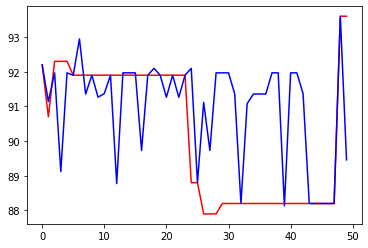

In [0]:


df_gru = pd.read_excel('imputed_data_epoch499.xlsx')
plt.plot(df["Area Planted"].iloc[0:50],color='r')
plt.plot(df_gru["Area Planted"].iloc[0:50],color='b')

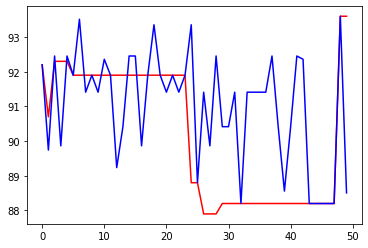

In [0]:
df_lime = pd.read_excel('imputed_data_epoch499.xlsx')
plt.plot(df["Area Planted"].iloc[0:50],color='r')
plt.plot(df_lime["Area Planted"].iloc[0:50],color='b')

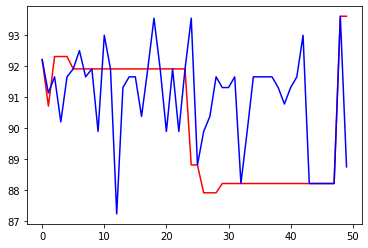

In [0]:
df_lime_rnn = pd.read_excel('imputed_data_epoch499.xlsx')
plt.plot(df["Area Planted"].iloc[0:50],color='r')
plt.plot(df_lime_rnn["Area Planted"].iloc[0:50],color='b')

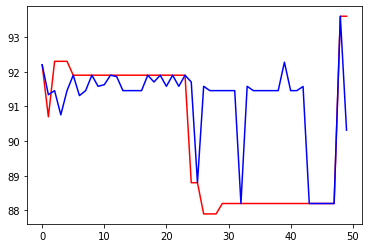

In [0]:
df_lime_rnn1 = pd.read_excel('imputed_data_epoch499.xlsx')
plt.plot(df["Area Planted"].iloc[0:50],color='r')
plt.plot(df_lime_rnn1["Area Planted"].iloc[0:50],color='b')

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_gru["Area Planted"],df['Area Planted'])

11.476973497130293

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_lime["Area Planted"],df['Area Planted'])

11.032904824110823

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_lime_rnn["Area Planted"],df['Area Planted'])

11.408477420545507

In [0]:
f=open("household_power_consumption.txt", "r")
content =f.read()

In [0]:
print(content)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
df1 = pd.DataFrame([x.split(';') for x in content.split('\n')])

In [0]:
new_header = df1.iloc[0] #grab the first row for the header
df1 = df1[1:] #take the data less the header row
df1.columns = new_header #set the header row as the df header

In [0]:
df1.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075256,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.000
2075257,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.000
2075258,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.000
2075259,26/11/2010,21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.000
2075260,,None,None,None,None,None,None,None,None


In [0]:
xyz=pd.read_excel('imputed_data_epoch999.xlsx')

In [0]:
random = pd.read_excel('missing_data.xlsx').iloc[:,1:6]
random.head()

,Area Planted,Area Harvested,Beginning Stocks,Production,Imports
0,NaN,NaN,937.0,12460.0,NaN
1,90.5,NaN,987.0,12460.0,15.0
2,NaN,NaN,1137.0,12840.0,15.0
3,NaN,85.4,1137.0,NaN,15.0
4,NaN,85.4,1142.0,13308.0,15.0


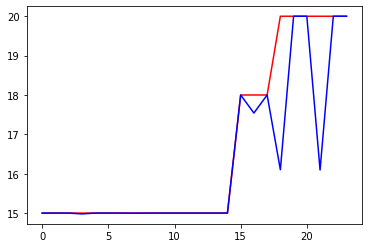

In [0]:
plt.plot(df['Imports'],color='r')
plt.plot(xyz['Imports'],color='b')

In [0]:
miss_data[0]

array([-128.        ,   -3.0443754 , -128.        ,   -3.22317953,
       -128.        ])

In [0]:
def run_epoch(session, model, data, eval_op):
	header_pre = []
	pre = []
	for step,(x,y) in enumerate(reader.ptb_iterator(data, model.batch_size,model.num_steps,FLAGS.embedding_size)):
		_, prediction= session.run([eval_op, model.prediction],
                                 {model.input_data: x,
                                  model.targets:    y})
		if step == 0:			
			header_pre.append(prediction[:model.num_steps-1,:])
		for i in range(model.batch_size):
			pre.append(prediction[(i+1)*model.num_steps - 1,:])
	
	return np.concatenate((np.array(header_pre).reshape(-1, FLAGS.embedding_size), np.array(pre)), axis=0)

In [0]:
config = get_config('Train')
miss_data, columns_name, norlizer = reader.read_data("missing_data.xlsx", missing_flag=FLAGS.missing_flag)

os.environ['CUDA_VISIBLE_DEVICES']='0'
gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True

with tf.Session(config=gpu_config) as session:
  initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)  
  with tf.variable_scope("LIMELSTM", reuse=None, initializer=initializer):
    model = LIMELSTM(is_training=True, config=config, FLAGS=FLAGS)   	        #train model,is_trainable=True
    
  tf.initialize_all_variables().run()
  model._lr = 0.01
  new_lr = model._lr
  for i in range(1000):
    print ('Number of iterations:',i)
    prediction = run_epoch(session, model, miss_data, model.train_op)
    if i >=500:
      print ('RMSE:', reader.RMSE_Metric(miss_data, np.concatenate((miss_data[0,:].reshape(1,-1), np.array(prediction)), axis=0), missing_flag=FLAGS.missing_flag))
    if i ==999:
      reader.save_data(miss_data, prediction, i, norlizer, columns_name, FLAGS.missing_flag)
    if i>=10 and i%10==0:
      if new_lr>0.005:new_lr=new_lr-0.003
      else:new_lr=new_lr*0.5
      model.assign_lr(session,new_lr)
  print(prediction)